In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os 
from typing import List
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
from PIL import Image
import torch
from metrics import AverageDisplacementError, FinalDisplacementError


from extract_data import ExtractPredictionDataset
from cvm import ConstantVelocityModel
from dataloader import PixWorldConverter

In [2]:
TRACKLET_LEN = 20
PREDICTION_LEN = 12
MIN_SPEED = 0.0
MAX_SPEED = 2.5
PATH = "../icra-magni-benchmark/data"  # path to preprocessed scenarios directory
MAPS_PATH = "../datasets/thor_magni_pub_ready/maps"  # path to obstacles maps directory
TEST_SCENARIO = "Scenario_3"

In [3]:
tracklets = ExtractPredictionDataset.get_tracklets_scenario(
    path=os.path.join(PATH, TEST_SCENARIO),
    tracklet_len=TRACKLET_LEN,
    min_speed=MIN_SPEED,
    max_speed=MAX_SPEED,
)
len(tracklets)

3023

In [4]:
cvm_cfg = {"pred_len": PREDICTION_LEN, "v0_mode": "constant", "v0_sigma": None}
cvm = ConstantVelocityModel(cvm_cfg)

In [5]:
def evaluate_dataset(predictor, data: List[pd.DataFrame], obs_len: int):
    """Evaluate dataset"""
    ade = AverageDisplacementError()
    fde = FinalDisplacementError()
    obs_dataset = list(map(lambda x: x.iloc[:obs_len], data))
    gt_dataset = list(map(lambda x: x.iloc[obs_len:][["x", "y"]].values, data))

    y_hat = predictor.predict_dataset(obs_dataset)
    y_true = np.stack(gt_dataset).astype(float)

    ade.update(preds=torch.from_numpy(y_hat), target=torch.from_numpy(y_true))
    fde.update(preds=torch.from_numpy(y_hat), target=torch.from_numpy(y_true))
    ade_res = ade.compute().item()
    fde_res = fde.compute().item()
    ade.reset()
    fde.reset()
    return ade_res, fde_res

In [6]:
ade, fde = evaluate_dataset(predictor=cvm, data=tracklets, obs_len=8)
ade, fde

3023it [00:04, 735.21it/s]


(1.0534297227859497, 2.419647455215454)

# Check predictions

In [7]:
observations = [tracklet.iloc[:8] for tracklet in tracklets]
predictions = cvm.predict_dataset(observations)
ground_truth = [tracklet.iloc[8:] for tracklet in tracklets]

3023it [00:04, 729.22it/s]


In [8]:
if MAPS_PATH:
    with open(os.path.join(MAPS_PATH, "offsets.json"), "rb") as f:
        offsets = json.load(f)
    pix2word_converters = dict(
        May=PixWorldConverter(dict(resolution_pm=0.01, offset=offsets["May"])),
        September=PixWorldConverter(dict(resolution_pm=0.01, offset=offsets["September"])),
)

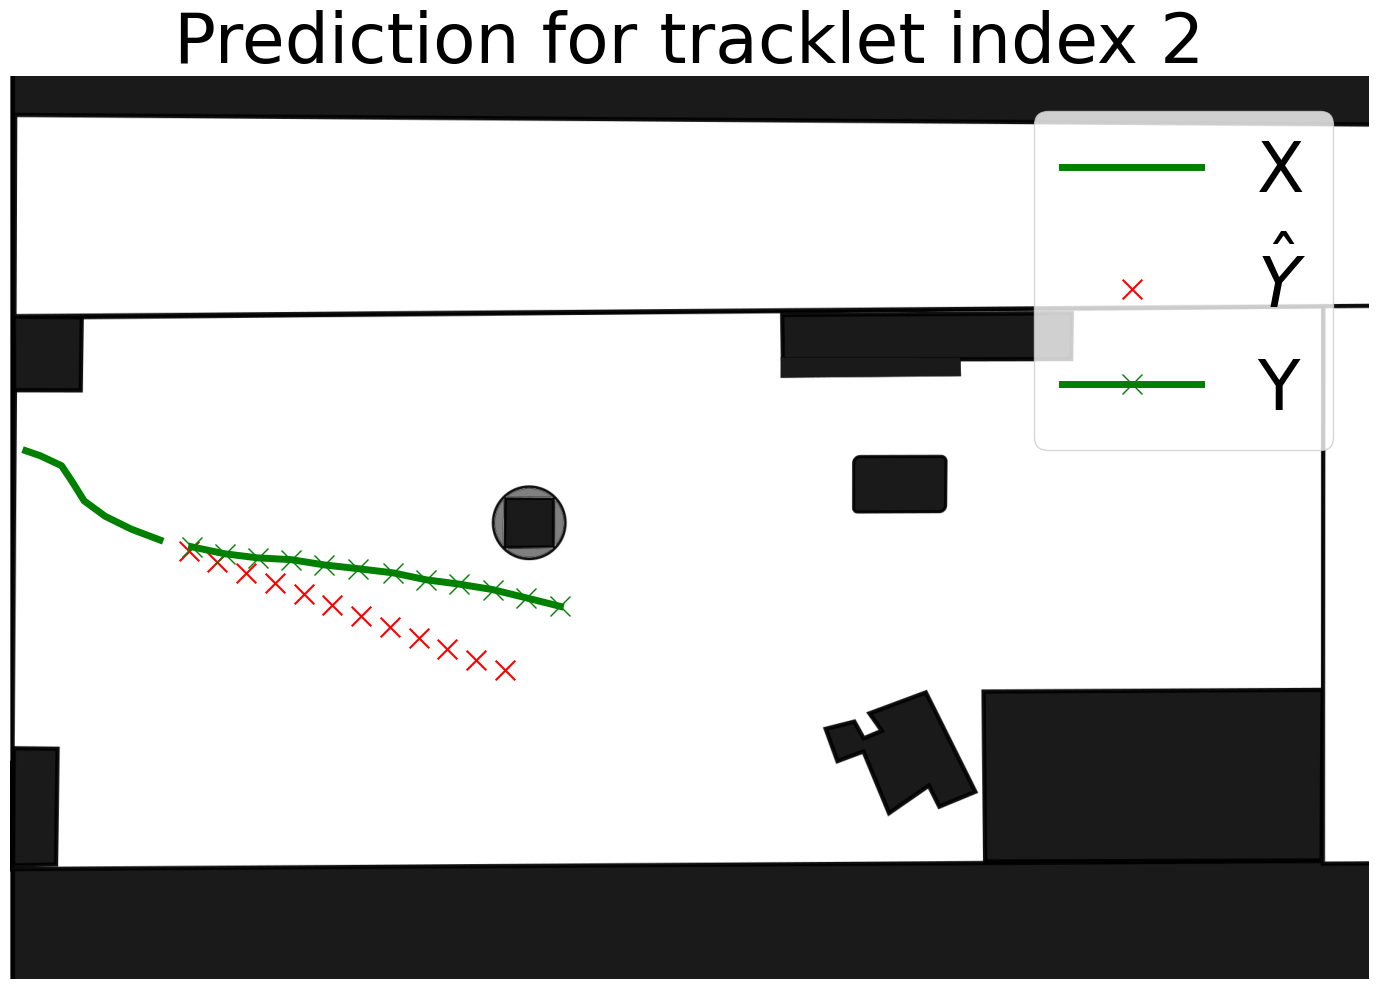

In [9]:
TRACKLET_INDEX = 2
plt.figure(figsize=(20, 10))
plt.title(f"Prediction for tracklet index {TRACKLET_INDEX}", fontsize=50)
observations_plt = observations[TRACKLET_INDEX]
predictions_plt = predictions[TRACKLET_INDEX]
ground_truth_plt = ground_truth[TRACKLET_INDEX]


if MAPS_PATH:
    map_name = observations[TRACKLET_INDEX]["map_name"].iloc[0]
    img = np.array(Image.open(os.path.join(MAPS_PATH, map_name)))
    spatial_layout = np.flipud(img[:, :, :3])
    plt.imshow(spatial_layout)
    month = "September" if map_name.startswith("3009") else "May"
    obs_px = pix2word_converters[month].convert2pixels(observations_plt[["x", "y"]].values)
    gt_px = pix2word_converters[month].convert2pixels(ground_truth_plt[["x", "y"]].values)
    observations_plt = observations_plt.copy()
    ground_truth_plt = ground_truth_plt.copy()
    observations_plt[["x", "y"]] = obs_px
    ground_truth_plt[["x", "y"]] = gt_px
    predictions_plt = pix2word_converters[month].convert2pixels(predictions_plt)
    
    
plt.plot(
    observations_plt["x"],
    observations_plt["y"],
    color="green",
    label = "X",
    linewidth=5,
)
plt.scatter(
    predictions_plt[:, 0],
    predictions_plt[:, 1],
    color="red",
    marker="x", 
    label = r"$\hat{Y}$",
    s=200,
)
plt.plot(
    ground_truth_plt["x"],
    ground_truth_plt["y"],
    color="green",
    marker="x", 
    label = r"Y",
    linewidth=5,
    markersize=15,
)
plt.legend(fontsize=50);
plt.axis("off")
plt.xlim([0, 1850])
plt.ylim([500, 1730])
plt.tight_layout()